In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [20]:
def get_clean_data(df_original):
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'V', 'I')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    df = df[df.index < '2017']
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    
    return clean_df

### Secondary band price

In [21]:
raw_band_price = pd.read_csv('export_PrecioBandaDeRegulaciónSecundaria_2017-01-15_19-11.csv', encoding='latin1', delimiter=';')

In [22]:
band_price = get_clean_data(raw_band_price)

In [23]:
#Mean price
year_weekday_hour_band_price = band_price[['year', 'season', 'weekday', 'hour', 'value']].groupby(['year', 'season', 'weekday', 'hour']).mean().unstack(-1)
year_weekday_hour_band_price.columns = year_weekday_hour_band_price.columns.droplevel(0)

In [24]:
#Std price
year_weekday_hour_band_price_std = band_price[['year', 'season', 'weekday', 'hour', 'value']].groupby(['year', 'season', 'weekday', 'hour']).std().unstack(-1)
year_weekday_hour_band_price_std.columns = year_weekday_hour_band_price_std.columns.droplevel(0)

### Find a relation between secondary band price and other measures

###### Band requirements

In [69]:
raw_band_req= pd.read_csv('export_RequerimientosBandaDeRegulaciónSecundariaABajar_2017-02-02_09-11.csv', encoding='latin1', delimiter=';')

In [70]:
band_req = get_clean_data(raw_band_req)

In [75]:
band_price_req = band_price[['value']].merge(band_req[['value']], how='left', left_index=True, right_index=True)
band_price_req.columns = ['price', 'req']

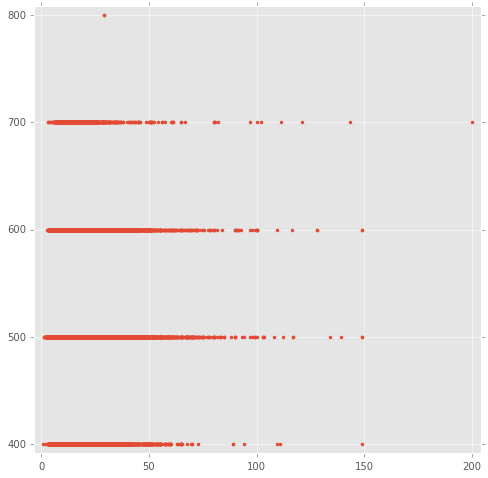

In [79]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(band_price_req['price'], band_price_req['req'], marker='.', linestyle='none'),
ax.margins(0.02)

##### Band allocation

In [80]:
raw_band_allocation = pd.read_csv('export_AsignaciónBandaDeRegulaciónSecundariaABajar_2017-02-02_09-15.csv', encoding='latin1', delimiter=';')

In [81]:
band_allocation = get_clean_data(raw_band_allocation)

In [90]:
band_price_allocation = band_price[['value']].merge(band_allocation[['value']], how='left', left_index=True, right_index=True)
band_price_allocation.columns = ['price', 'allocation']

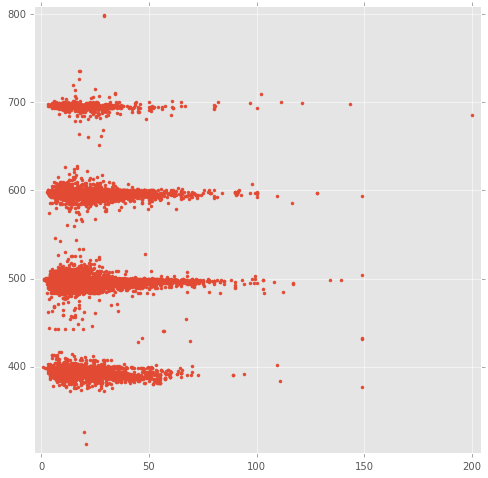

In [92]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(band_price_allocation['price'], band_price_allocation['allocation'], marker='.', linestyle='none'),
ax.margins(0.02)

##### Programmed demand

In [93]:
raw_demand_prog = pd.read_csv('export_DemandaProgramada_2017-02-02_09-45.csv', encoding='latin1', delimiter=';')

In [94]:
demand_prog = get_clean_data(raw_demand_prog)

In [101]:
band_price_deman_prog = band_price[['value']].merge(demand_prog[['value']], how='left', left_index=True, right_index=True)
band_price_deman_prog.columns = ['price', 'demand']

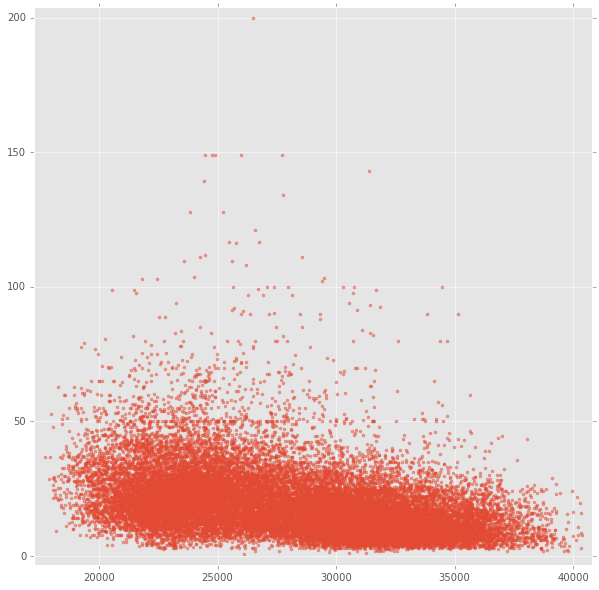

In [107]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(band_price_deman_prog['demand'], band_price_deman_prog['price'], marker='.', linestyle='none', alpha=0.5)
ax.margins(0.02);

In [125]:
np.corrcoef(band_price_deman_prog.values.T)

array([[ 1.        , -0.40300454],
       [-0.40300454,  1.        ]])

##### Spot price DAM

In [108]:
raw_spot_price = pd.read_csv('export_PrecioMercadoSPOTDiario_2017-02-02_09-47.csv', encoding='latin1', delimiter=';')

In [112]:
raw_spot_price = raw_spot_price[raw_spot_price['geoid'] == 3]

In [113]:
spot_price = get_clean_data(raw_spot_price)

In [118]:
band_spot_price = band_price[['value']].merge(spot_price[['value']], how='left', left_index=True, right_index=True)
band_spot_price.columns = ['band', 'spot']

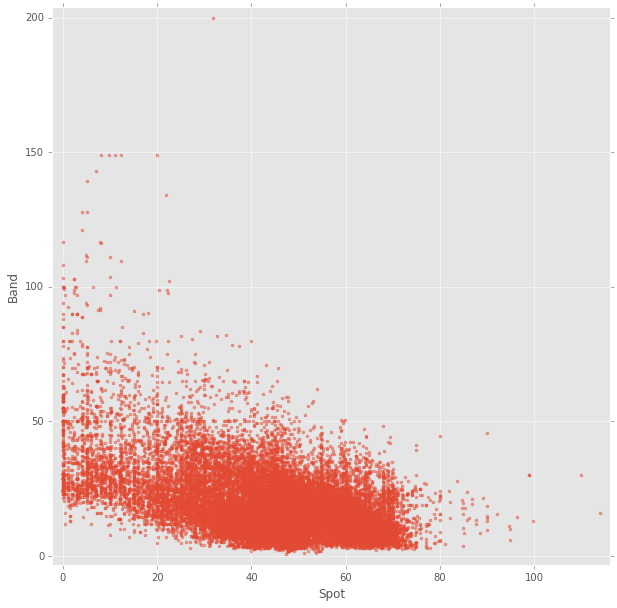

In [120]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(band_spot_price['spot'], band_spot_price['band'], marker='.', linestyle='none', alpha=0.5)
ax.set_xlabel('Spot')
ax.set_ylabel('Band')
ax.margins(0.02);

In [124]:
np.corrcoef(band_spot_price.values.T)

array([[ 1.        , -0.48185622],
       [-0.48185622,  1.        ]])

##### Energy allocated on DAM

In [126]:
raw_energy_dam = pd.read_csv('export_EnergíaAsignadaEnMercadoSPOTDiarioEspaña_2017-02-02_09-28.csv', encoding='latin1', delimiter=';')

In [128]:
energy_dam = get_clean_data(raw_energy_dam)

### Year TS and log scale

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,10))
for axx, year in zip((ax0, ax1, ax2), [2014, 2015, 2016]):
    axx.plot(band_price[band_price['year'] == year]['value'])

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,10))
for axx, year in zip((ax0, ax1, ax2), [2014, 2015, 2016]):
    axx.plot(np.log1p(band_price[band_price['year'] == year]['value']))

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20,10))
ax0.plot(band_price['value'])
ax1.plot(np.log1p(band_price['value']));

### Heatmap per year, season, weekday and hour

In [ ]:
for year in [2014, 2015, 2016]:
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=(18,10))
    #Use v_max, vmin to plot with same colors
    for axis, season in zip([ax0, ax1], ['V', 'I']):
        sns.heatmap(year_weekday_hour_band_price.loc[year, season], ax=axis, vmax=46, vmin=7)
        axis.set_title(str(year) + '-' + season)

In [ ]:
for year in [2014, 2015, 2016]:
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=(18,10))
    #Use v_max, vmin to plot with same colors
    for axis, season in zip([ax0, ax1], ['V', 'I']):
        sns.heatmap(year_weekday_hour_band_price_std.loc[year, season], ax=axis, vmax=40, vmin=3)
        axis.set_title(str(year) + '-' + season)

### Check rolling mean and std by day, week, month

In [ ]:
def plot_rolling_mean_std(series, window, ax1, ax2=None):
    #Rolling statistics
    rolmean = pd.rolling_mean(series, window=window)
    rolstd = pd.rolling_std(series, window=window)
    
    label_dict={
            24:'day',
            48:'two-day',
            168:'week',
            720:'month',
            8760:'year'
    }
    
    ax1.plot(rolmean, label=label_dict[window] + '- mean')
    if ax2 != None:
        ax2.plot(rolstd, label=label_dict[window] + '- std')

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20,10))
for window in [24, 48, 168, 720, 8760]:
    plot_rolling_mean_std(band_price['value'], window, ax0, ax1)
    ax0.legend(loc='best')
    ax1.legend(loc='best')

In [ ]:
#With log transformation 
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20,10))
for window in [24, 48, 168, 720, 8760]:
    plot_rolling_mean_std(np.log1p(band_price['value']), window, ax0, ax1)
    ax0.legend(loc='best')
    ax1.legend(loc='best')

In [ ]:
def remove_rolling_mean(series, window, ax):
    rolmean=pd.rolling_mean(series, window=window)
    series_rolling_mean_diff = series - rolmean
    label_dict={
            24:'day',
            48:'two-day',
            168:'week',
            720:'month',
            8760:'year'
    }
    ax.plot(series_rolling_mean_diff, label='original minus rolling mean')
    for window_roll in [24, 48, 168, 720, 8760]:
        plot_rolling_mean_std(series_rolling_mean_diff, window_roll, ax)

In [ ]:
for window in [24, 48, 168, 720, 8760]:
    fig, ax = plt.subplots(1,1, figsize=(20,7))
    remove_rolling_mean(band_price['value'], window, ax)
    ax.legend(loc=0)
    ax.set_title('TS removing rolling mean of ' + str(window))

### Apply log transformation and remove rolling mean of 24 hours

In [ ]:
log_band_price = band_price.copy(deep=True)

In [ ]:
log_band_price['value'] = np.log1p(log_band_price['value'])

In [ ]:
log_band_price['value_rolling_mean_24_diff'] =  log_band_price['value'] - pd.rolling_mean(log_band_price['value'], window=24)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(20,10))
ax0.plot(log_band_price['value'])
ax0.set_title('Log-scale secondary band price')
ax1.plot(log_band_price['value_rolling_mean_24_diff'])
ax1.set_title('Log-scale secondary band price removing 24-hour rolling mean');

In [ ]:
log_band_price['value_ewma_24_hours'] = log_band_price['value'] - pd.ewma(log_band_price['value'], halflife=24)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(20,10))
ax0.plot(log_band_price['value'])
ax0.set_title('Log-scale secondary band price')
ax1.plot(log_band_price['value_ewma_24_hours'])
ax1.set_title('Log-scale secondary band price removing 24-hour exponential weighted moving average');

### Trend and seasonality decomposition

In [ ]:
import statsmodels.api as sm

In [ ]:
decomposition = sm.tsa.seasonal_decompose(band_price['value'], freq=24)

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(20,15))
ax0.plot(band_price['value'])
ax1.plot(decomposition.trend)
ax2.plot(decomposition.seasonal[26000:])
ax3.plot(decomposition.resid);

### Dick-Fuller test on stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [ ]:
perform_stationarity_test(band_price['value'])

In [ ]:
perform_stationarity_test(log_band_price['value'])

In [ ]:
perform_stationarity_test(log_band_price['value_rolling_mean_24_diff'].dropna())

In [ ]:
perform_stationarity_test(log_band_price['value_ewma_24_hours'].dropna())

### ACF and PACF

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
def compute_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries.dropna(), nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name='Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

In [ ]:
compute_acf_pacf(log_band_price['value_rolling_mean_24_diff'], 720, 720)

In [ ]:
compute_acf_pacf((log_band_price['value']-log_band_price['value'].shift()).dropna(), 720, 720)

In [ ]:
compute_acf_pacf(log_band_price['value_rolling_mean_24_diff'], 170, 170)

### ARIMA Model, p=2; q=5

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
def compute_ARIMA_model_plot_residuals(timeseries, p,d,q):
    model = ARIMA(timeseries.dropna(), order=(p,d,q))
    results = model.fit(disp=-1, maxiter=1000)
    
    if d > 0:
        timeseries_diff = timeseries.dropna() - timeseries.dropna().shift(d)
        rss = ((results.fittedvalues - timeseries_diff.dropna())**2).sum()
        return rss, timeseries_diff.dropna(), results.fittedvalues
    else:
        rss = ((results.fittedvalues - timeseries.dropna())**2).sum()
        return rss, timeseries.dropna(), results.fittedvalues

In [ ]:
def plot_original_ts_and_estimated(rss, original, estimated, initial, end):
    fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,10))
    for axx, year in zip((ax0, ax1, ax2), [2014, 2015, 2016]):
        axx.plot(original[original.index.year == year].iloc[initial:end])
        axx.plot(estimated[estimated.index.year == year].iloc[initial:end])
    ax0.set_title('RSS: {0:.2f}'.format(rss))

In [ ]:
rss, original_ts, estimated_ts = compute_ARIMA_model_plot_residuals(log_band_price['value_rolling_mean_24_diff'], 2,1,5)

In [ ]:
plot_original_ts_and_estimated(rss, original_ts, estimated_ts, 7000, 7200)

In [ ]:
rss_2, original_2, estimated_2 =compute_ARIMA_model_plot_residuals(log_band_price['value_rolling_mean_24_diff'], 4,0,7)

In [ ]:
np.sum(((np.exp(original_2) - np.exp(estimated_2))**2))/len(original_2)

In [ ]:
(np.exp(original_2) - np.exp(estimated_2)).iloc[9500:9700].plot(figsize=(20,10))

In [ ]:
log_band_price['value_rolling_mean_24_diff'].dropna().shape

In [ ]:
original_2.head(3)

In [ ]:
estimated_2.head(3)

In [ ]:
plot_original_ts_and_estimated(rss_2, original_2, estimated_2, 0, 168)

In [ ]:
rss_2, original_2, estimated_2 =compute_ARIMA_model_plot_residuals(log_band_price['value_rolling_mean_24_diff'], 4,0,7)

In [ ]:
((((np.exp(original_2) - np.exp(estimated_2))**2)).sum())/len(original_2)

In [ ]:
((((original_2 - estimated_2)**2)).sum())/len(original_2)

In [ ]:
np.exp(original_2).iloc[12000:12020].plot(figsize=(20,10))
np.exp(estimated_2).iloc[12000:12020].plot(figsize=(20,10))

In [ ]:
np.exp(original_2).iloc[12000:12020]

In [ ]:
np.exp(estimated_2).iloc[12000:12020]

In [ ]:
np.exp(estimated_2).iloc[12000:12024]

In [ ]:
plot_original_ts_and_estimated(rss_2, original_2, estimated_2, 8700, 8760)

In [ ]:
log_band_price['prueba'] = pd.rolling_mean(log_band_price['value'].shift(24), window=24)

In [ ]:
log_band_price['prueba_2'] = log_band_price['value'] - log_band_price['prueba']

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(20,10))
ax0.plot(log_band_price['value'].iloc[24000:25000])
ax0.set_title('Log-scale secondary band price')
ax1.plot(log_band_price['prueba_2'].iloc[24000:25000])
ax1.set_title('Log-scale secondary band price removing 24-hour moving average of d-2');

In [ ]:
perform_stationarity_test(log_band_price['prueba_2'].dropna())

In [ ]:
compute_acf_pacf(log_band_price['prueba_2'], 720, 720)

In [ ]:
a, b,c = compute_ARIMA_model_plot_residuals(log_band_price['prueba_2'], 2, 0, 7)

In [ ]:
a